#### CAUTION !!

・sequence lengthごとにMinMaxScaleをしているため、全体のグラフをプロットすると不自然な形になっている

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np

from Stock_Loader import load_data
from Stock_Preprocessor import process, fast_plot
from Stock_RNN import get_model_0
from Stock_RNN_Embed import get_model_1
from Stock_RNN_Positional import get_model_2
from Stock_RNN_Positional_Changed import get_model_2_
from Stock_Transformer import get_model_3
from Stock_Align_Dataset import clean_and_align
from Stock_Utils import *

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

from importlib import reload

import math

In [210]:
### RELOAD ###

import Stock_Preprocessor
import Stock_Loader
import Stock_RNN
import Stock_RNN_Embed
import Stock_RNN_Positional
import Stock_RNN_Positional_Changed
import Stock_Transformer
import Stock_Align_Dataset
import Stock_Utils

reload(Stock_Preprocessor)
reload(Stock_RNN)
reload(Stock_RNN_Embed)
reload(Stock_RNN_Positional)
reload(Stock_RNN_Positional_Changed)
reload(Stock_Loader)
reload(Stock_Align_Dataset)
reload(Stock_Utils)
reload(Stock_Transformer)

from Stock_Loader import load_data
from Stock_Preprocessor import process, fast_plot
from Stock_RNN import get_model_0
from Stock_RNN_Embed import get_model_1
from Stock_RNN_Positional import get_model_2
from Stock_RNN_Positional_Changed import get_model_2_
from Stock_Transformer import get_model_3
from Stock_Align_Dataset import clean_and_align
from Stock_Utils import *

In [5]:
df_appl = load_data("../Datasets/dataset.csv")

...Downloading Datasets
...Adding Values to Datasets
...Done !!


In [6]:
###### DOWNLOADED #######

df_appl.iloc[42364:42366] # 2018-02-15 -> apple revenue hit all time hight

,TimeStamp,Open,High,Low,Close,Volume,Year,Month,Day,Hour,Day_of_Week
42364,2018-02-14 16:00:00,167.32,167.45,167.3,167.37,2.03295e+06,2018,2,14,16,2
42365,2018-02-15 09:30:00,169.79,169.86,169.36,169.84,791331,2018,2,15,9,3


In [7]:
###############
## For Debugging ##
###############

# df_sample = df_appl.iloc[:300]

# df_ran = df_sample.columns.tolist()
# df_ran = df_ran[::-1]
# df_sample = df_sample[df_ran]

# df_sample.head()

In [8]:
###############
## For Debugging ##
###############

# feature = ["Close", "Open", "High", "Low", "Volume", "Year", "Month", "Hour", "Day_of_Week"]
# feature_range=(-1,1)

# df_sample_aligned, features, categorical_index = clean_and_align(df_sample, feature, debug=True)

In [9]:
###############
## For Debugging ##
###############

# seq_length = 10
# val_length = 60
# test_length = 60

# non_label_index = 4

# train, train_label, val, val_label, _test, _test_label, _test_seq, _meta, scaler =\
#                     process(df_sample_aligned, feature, feature_range, seq_length, val_length, test_length, categorical_index, non_label_index)

In [10]:
feature = ["Close", "Open", "High", "Low", "Volume", "Year", "Month", "Hour", "Day_of_Week"]

df_aligned, feature, categorical_index = clean_and_align(df_appl, feature, debug=True)

...186 row(s) dropped
...Done !!


In [11]:
seq_length = 120

feature_range=(-1,1)
non_label_index = 4

val_length = 600
test_length = 600

train, train_label, val, val_label, test, test_label, test_seq, meta, scaler =\
                                            process(df_aligned, feature, feature_range, seq_length, val_length, test_length, categorical_index, non_label_index)

...Categorical Index Enabled

...Transforming Datasets
...Transforming feature_0
...Transforming feature_1
...Transforming feature_2
...Transforming feature_3
...Transforming feature_4
...Transforming feature_5
...Transforming feature_6
...Transforming feature_7
...Transforming feature_8

...Concatenating Datasets

...Done ! Took 1691.9s to complete.


In [588]:
df_check = pd.DataFrame(train[0])
df_check.columns = feature
df_check.head(5)

,Close,Open,High,Low,Volume,Year,Month,Hour,Day_of_Week
0,-0.651639,-0.790984,-0.687885,-0.759834,-0.982224,2018.0,2.0,14.0,1.0
1,-0.639344,-0.655738,-0.671458,-0.672878,-0.977673,2018.0,2.0,14.0,1.0
2,-0.672090,-0.639344,-0.638604,-0.631470,-0.990830,2018.0,2.0,14.0,1.0
3,-0.594262,-0.663934,-0.634497,-0.627329,-0.992379,2018.0,2.0,14.0,1.0
4,-0.655738,-0.602459,-0.630390,-0.639752,-0.987966,2018.0,2.0,14.0,1.0


In [100]:
from sklearn.preprocessing import MinMaxScaler
a = df_appl[1000:1120]["Open"]
scaler = MinMaxScaler((-1, 1))
a_new = scaler.fit_transform(np.array(a).reshape(-1, 1))
a_new

array([[ 0.08108108],
       [ 0.56756757],
       [ 0.41621622],
       [ 0.62162162],
       [ 0.56756757],
       [ 0.40540541],
       [ 0.16216216],
       [ 0.08108108],
       [-0.35135135],
       [-0.2972973 ],
       [-0.13513514],
       [-0.13513514],
       [ 0.40540541],
       [ 0.56108108],
       [ 0.56756757],
       [ 0.92      ],
       [ 0.83783784],
       [ 0.54      ],
       [ 0.62108108],
       [ 0.59135135],
       [ 0.51351351],
       [ 0.40540541],
       [ 0.05405405],
       [ 0.40486486],
       [ 0.45945946],
       [ 0.18918919],
       [-0.08108108],
       [ 0.13513514],
       [-0.18918919],
       [-0.40540541],
       [-0.67621622],
       [-0.54054054],
       [-0.29675676],
       [ 0.05027027],
       [-0.2972973 ],
       [ 0.02702703],
       [-0.22108108],
       [-0.08162162],
       [-0.1572973 ],
       [-0.13513514],
       [-0.67567568],
       [-0.51351351],
       [-0.75027027],
       [-0.83783784],
       [-0.72972973],
       [-0

In [47]:
# Time Embedding
embed_dim = 1

# RNN
hidden_dim = 128
n_layers = 2
bidirectional = False
dropout = 0.1

# Transformer
n_layers = 4
nhead = 2
activation = "relu"
dropout = 0.1
d_feed = 16

In [48]:
# Model
input_size = (train.shape[2] - categorical_index) * embed_dim + categorical_index + 1
output_size = 4

# Scheduler
scheduler_step = [75, 100]
gamma = 0.1

# loss_function
lr = 0.001
mse_scaler = False
scale = 0.01

bt_size = 64

log_dir= "batch"


# model, optimizer, mse_loss, scheduler, writer = get_model_0(input_size, output_size, hidden_dim, n_layers, bidirectional, dropout,
#                                                              lr, scheduler_step, gamma, log_dir)

# model, optimizer, total_loss, scheduler, writer = get_model_1(input_size, output_size, embed_dim, hidden_dim, n_layers, bidirectional, dropout,
#                                                              lr, scheduler_step, gamma, log_dir, categorical_index)

# model, optimizer, total_loss, scheduler, writer = get_model_2_(input_size, output_size, embed_dim, bt_size, seq_length, 
#                                                               hidden_dim, n_layers, bidirectional, dropout, lr, scheduler_step, gamma, mse_scaler, log_dir, scale)

model, optimizer, total_loss, scheduler, writer = get_model_3(input_size, output_size, embed_dim, bt_size, seq_length,
                  n_layers, nhead, d_feed, activation, dropout, lr, scheduler_step, gamma, mse_scaler, log_dir, categorical_index, non_label_index, scale) 

In [234]:
writer = SummaryWriter(log_dir)

In [235]:
num_epochs = 150

acc = math.inf

best_acc = math.inf
best_model = model
loss_accumulated = []
sample = []

In [236]:
for epoch in range(num_epochs):
    
    for phase in ["train", "val"]:
        
        if phase == "train":
            
            model.train()
            
            for i in range(0, len(train)-1, bt_size):
                
                optimizer.zero_grad()
                
                inputs, targets = train[i:i+bt_size, :, :], train_label[i:i+bt_size, :]
                
                if inputs.shape[0] < bt_size: break
                
                inputs = torch.from_numpy(inputs).float()
                targets = torch.from_numpy(targets).float()
                
                outputs = model(inputs)

                loss = total_loss(inputs, targets, outputs)
                loss_accumulated.append(loss.item()*1000)
                
                loss.backward(retain_graph=True)
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                
                if (i % 3600 == 0) and (i > bt_size):
                    acc = sum(loss_accumulated)*(100) / (len(loss_accumulated))
                    print("....Processing {}th sample out of {} training set. Loss: {}".format(i+1,
                                                                                             len(train), acc))
                    writer.add_scalar("Train_Loss", acc,
                                                      (epoch)*(len(train) // 3600) + (i // 3600))
                    
                optimizer.step()
                scheduler.step()
                
            acc = sum(loss_accumulated)*(100) / (len(loss_accumulated))

            print()
            print("Epoch: {} Loss: {:.3f}".format(epoch, acc))
            print()
            
            loss_accumulated = []
            
            perm = np.random.permutation(train.shape[0])
            train, train_label = train[perm], train_label[perm]
            
        elif phase == "val":
            
            print("...Evaluation Mode")
            
            model.eval()
            
            with torch.no_grad():
                
                for i in range(0, len(val)-1, bt_size):

                    inputs, targets = val[i:i+bt_size,:,:], val_label[i:i+bt_size, :]
                    
                    if inputs.shape[0] < bt_size: break
                    
                    inputs = torch.from_numpy(inputs).float()
                    targets = torch.from_numpy(targets).float()
                    
                    outputs = model(inputs)
                    
                    loss = total_loss(inputs, targets, outputs)
                    loss_accumulated.append(loss.item()*1000)
                
                acc = sum(loss_accumulated)*(100) / (len(loss_accumulated))

                writer.add_scalar("Val_Loss", acc, epoch)
                
#                 baseline = result_compare(model, test, test_label, [i for i in range(len(test))], feature, non_label_index, positional_bt_size, False)
                
#                 print("Validation: {:.3f}, Baseline: {:.3f}".format(acc, baseline))
        
                print("Validation: {:.3f}".format(acc))
                
                if acc < best_acc:
                    best_model = model
                    best_acc = acc
                    print("MODEL UPDATED !!")
                
                loss_accumulated = []
                
                perm = np.random.permutation(val.shape[0])
                val, val_label = val[perm], val_label[perm]
                
    print("-" * 70)
    print()

....Processing 14401th sample out of 41640 training set. Loss: 2050.2605450759947
....Processing 28801th sample out of 41640 training set. Loss: 1930.5222748289352

Epoch: 0 Loss: 1935.918

...Evaluation Mode
Validation: 918.207
MODEL UPDATED !!
----------------------------------------------------------------------

....Processing 14401th sample out of 41640 training set. Loss: 1899.9798841510726
....Processing 28801th sample out of 41640 training set. Loss: 1891.5933835631993

Epoch: 1 Loss: 1932.379

...Evaluation Mode
Validation: 559.944
MODEL UPDATED !!
----------------------------------------------------------------------

....Processing 14401th sample out of 41640 training set. Loss: 1917.7582213836433
....Processing 28801th sample out of 41640 training set. Loss: 1913.2069146834694

Epoch: 2 Loss: 1926.989

...Evaluation Mode
Validation: 563.025
----------------------------------------------------------------------

....Processing 14401th sample out of 41640 training set. Loss: 

KeyboardInterrupt: 

In [237]:
# torch.save(model, "stock_model_v9")

In [215]:
# temp_model = model

In [228]:
model = torch.load("../Model/stock_model_v2")

In [224]:
# Config for baseline calculation

shrink_to = -1 # v0, v1, v2, v3 -> 4 | v4 ~ -> -1
non_label_index = 4 # v0, v1, v2, v3 -> 5 | v4 ~ -> 4 
remove_non_label_index = False # v6 ~ False

In [225]:
test.shape

(480, 120, 9)

In [226]:
result_compare(model, test, test_label, [i for i in range(20)], feature, bt_size, non_label_index,
                                                                                                                                                               shrink_to, remove_non_label_index, True)

----------------------------------------------------------------------
idx:   0
                                   	['Close', 'Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Hour', 'Day_of_Week']

Predicted(y_pred)  :	[0.9260298 0.9528389 0.9346224 0.94961  ]
Target(y^)               :	[1.      1.      1.      0.96875]

Last Price(y-1)        :	[0.88197026 1.         0.95081967 1.        ]

(y^ - (y_pred))      => 20.074787139892578
(y^ - (y-1))             => 22.8915958404541
----------------------------------------------------------------------
----------------------------------------------------------------------
idx:   1
                                   	['Close', 'Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Hour', 'Day_of_Week']

Predicted(y_pred)  :	[0.5230735  0.5441913  0.5122508  0.56266576]
Target(y^)               :	[1. 1. 1. 1.]

Last Price(y-1)        :	[-1.          0.84496124  0.952       0.8778626 ]

(y^ - (y_pred))      => 18.14572525024414
(y^ - (y-1))     

----------------------------------------------------------------------
idx:  15
                                   	['Close', 'Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Hour', 'Day_of_Week']

Predicted(y_pred)  :	[0.84672844 0.86583275 0.8548614  0.8651281 ]
Target(y^)               :	[0.87924528 0.81818182 0.87096774 0.89473684]

Last Price(y-1)        :	[0.83396226 0.96969697 0.96774194 0.86466165]

(y^ - (y_pred))      => 16.94706153869629
(y^ - (y-1))             => 22.058025360107422
----------------------------------------------------------------------
----------------------------------------------------------------------
idx:  16
                                   	['Close', 'Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Hour', 'Day_of_Week']

Predicted(y_pred)  :	[0.8852912  0.9122996  0.888222   0.91425836]
Target(y^)               :	[0.73856604 0.88636364 0.86290323 0.80451128]

Last Price(y-1)        :	[0.87924528 0.81818182 0.87096774 0.89473684]

(y^ - (y_pred)

### Validation

分散された位置からとってきた方がいい（今のままだと連続したところからとってきている）

### Embedding

embeddingそのものをどれくらい考慮するかもnetworkでやるべきか

### やること

・　dataをとってくる (screen embedding)
・ baysean optimizationでparmeter search
・ trading volumeを入れる
・　kafka
・sparkでprocessing

### align

・ align時にnon_label, categoricalを分ける

In [215]:
torch.from_numpy(test[i:i+1, :, :]).float().shape

torch.Size([1, 120, 9])

In [214]:
test_label_list = []

for i in range(480):
    out = model(torch.from_numpy(test[i:i+, :, :4]).float()) # test[i:i+1, :, :4]
    out = out.detach().numpy().reshape(1,4) # .reshape(1,4)
    
    min_ = test[i:i+1, :, 0].min()
    max_ = test[i:i+1, :, 0].max()
    
    min_idx = -1
    max_idx = -1
    
    for j in range(test.shape[1]):
        if test[i:i+1, j, 0] == min_:
            min_idx = j
    
    for k in range(test.shape[1]):
        if test[i:i+1, k, 0] == max_:
            max_idx = k
    
    min_val = test_seq[0][i+min_idx][0]
    max_val = test_seq[0][i+max_idx][0]
    
    original = out[0][0] * (max_val - min_val) + min_val
    
    test_label_list.append(original)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 2. Got 1 and 64 in dimension 0 at /Users/distiller/project/conda/conda-bld/pytorch_1573049287641/work/aten/src/TH/generic/THTensor.cpp:689

In [252]:
sum(diff) / len(diff)

0.5837099056962065

In [251]:
test_label_list = []
diff = []

for i in range(480):
    if i == 479:
        break
        
    out = model(torch.from_numpy(test[i:i+1, :, :4]).float())
    out = out.detach().numpy().reshape(1,4)
    
    min_ = test[i:i+1, :, 0].min()
    max_ = test[i:i+1, :, 0].max()
    
    min_idx = -1
    max_idx = -1
    
    for j in range(test.shape[1]):
        if test[i:i+1, j, 0] == min_:
            min_idx = j
    
    for k in range(test.shape[1]):
        if test[i:i+1, k, 0] == max_:
            max_idx = k
    
    min_val = test_seq[0][i+min_idx][0]
    max_val = test_seq[0][i+max_idx][0]
    
    original = out[0][0] * (max_val - min_val) + min_val

    diff.append(abs(original-test_seq[0][i+120+1][0]))
    
    test_label_list.append(original)

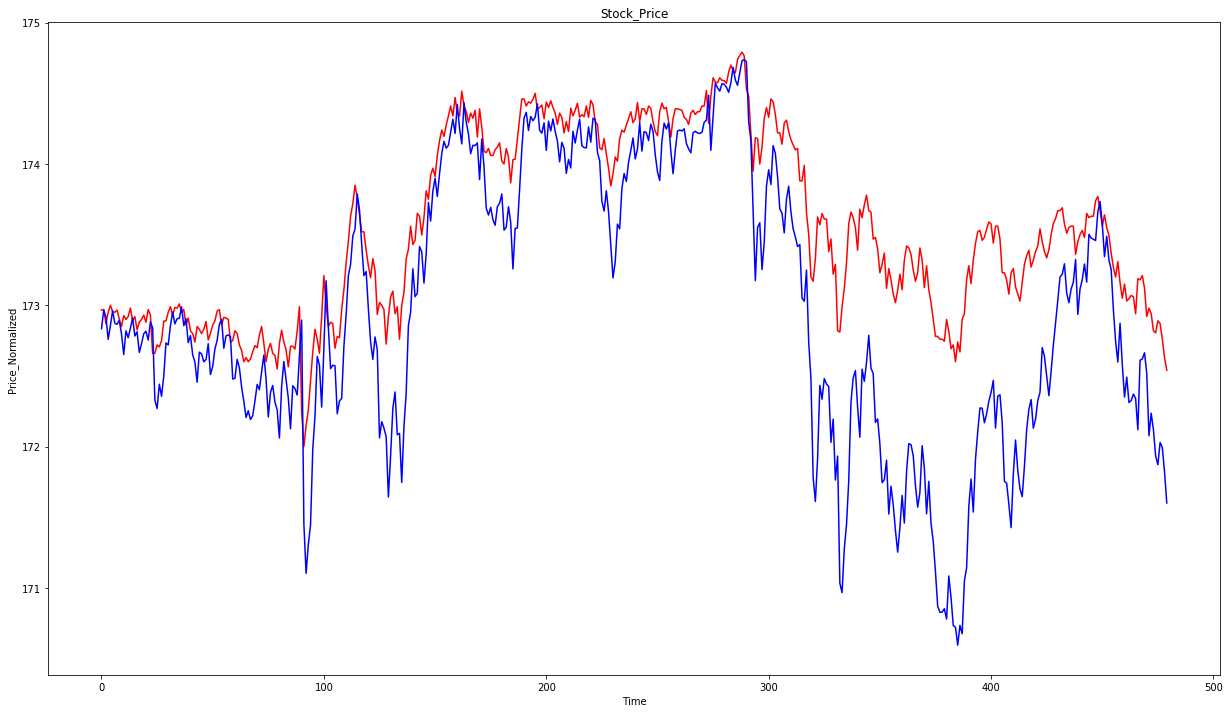

In [232]:
fast_plot(test_seq[0][120:], np.array(test_label_list).reshape(-1,1))

In [1]:
###########################################
###STEP 1 まずEmbeddingなしでClose Priceだけで予測する##
###########################################

In [2]:
##########################################
############STEP 2 Price4つを加える#############
##########################################

In [3]:
##########################################
###########STEP 3 Parametersをいじくる###########
##########################################

In [ ]:
##########################################
########STEP 4 Time Embeddingsを加える##########
##########################################

In [ ]:
##########################################
######STEP 5 Positional Embeddingsを加える#########
##########################################

In [ ]:
##########################################
###########STEP 6 Loss Functionを変える##########
##########################################

In [4]:
##########################################
########STEP 5 Transformerを使って予測する#########
##########################################

In [7]:
##########################################
########STEP 7 Company Embeddingを加える########
##########################################

In [8]:
##########################################
########STEP 8 Day, Hour, MinuteをMixする##########
##########################################